![Screenshot 2024-10-08 at 14.48.22.png](<attachment:Screenshot 2024-10-08 at 14.48.22.png>)
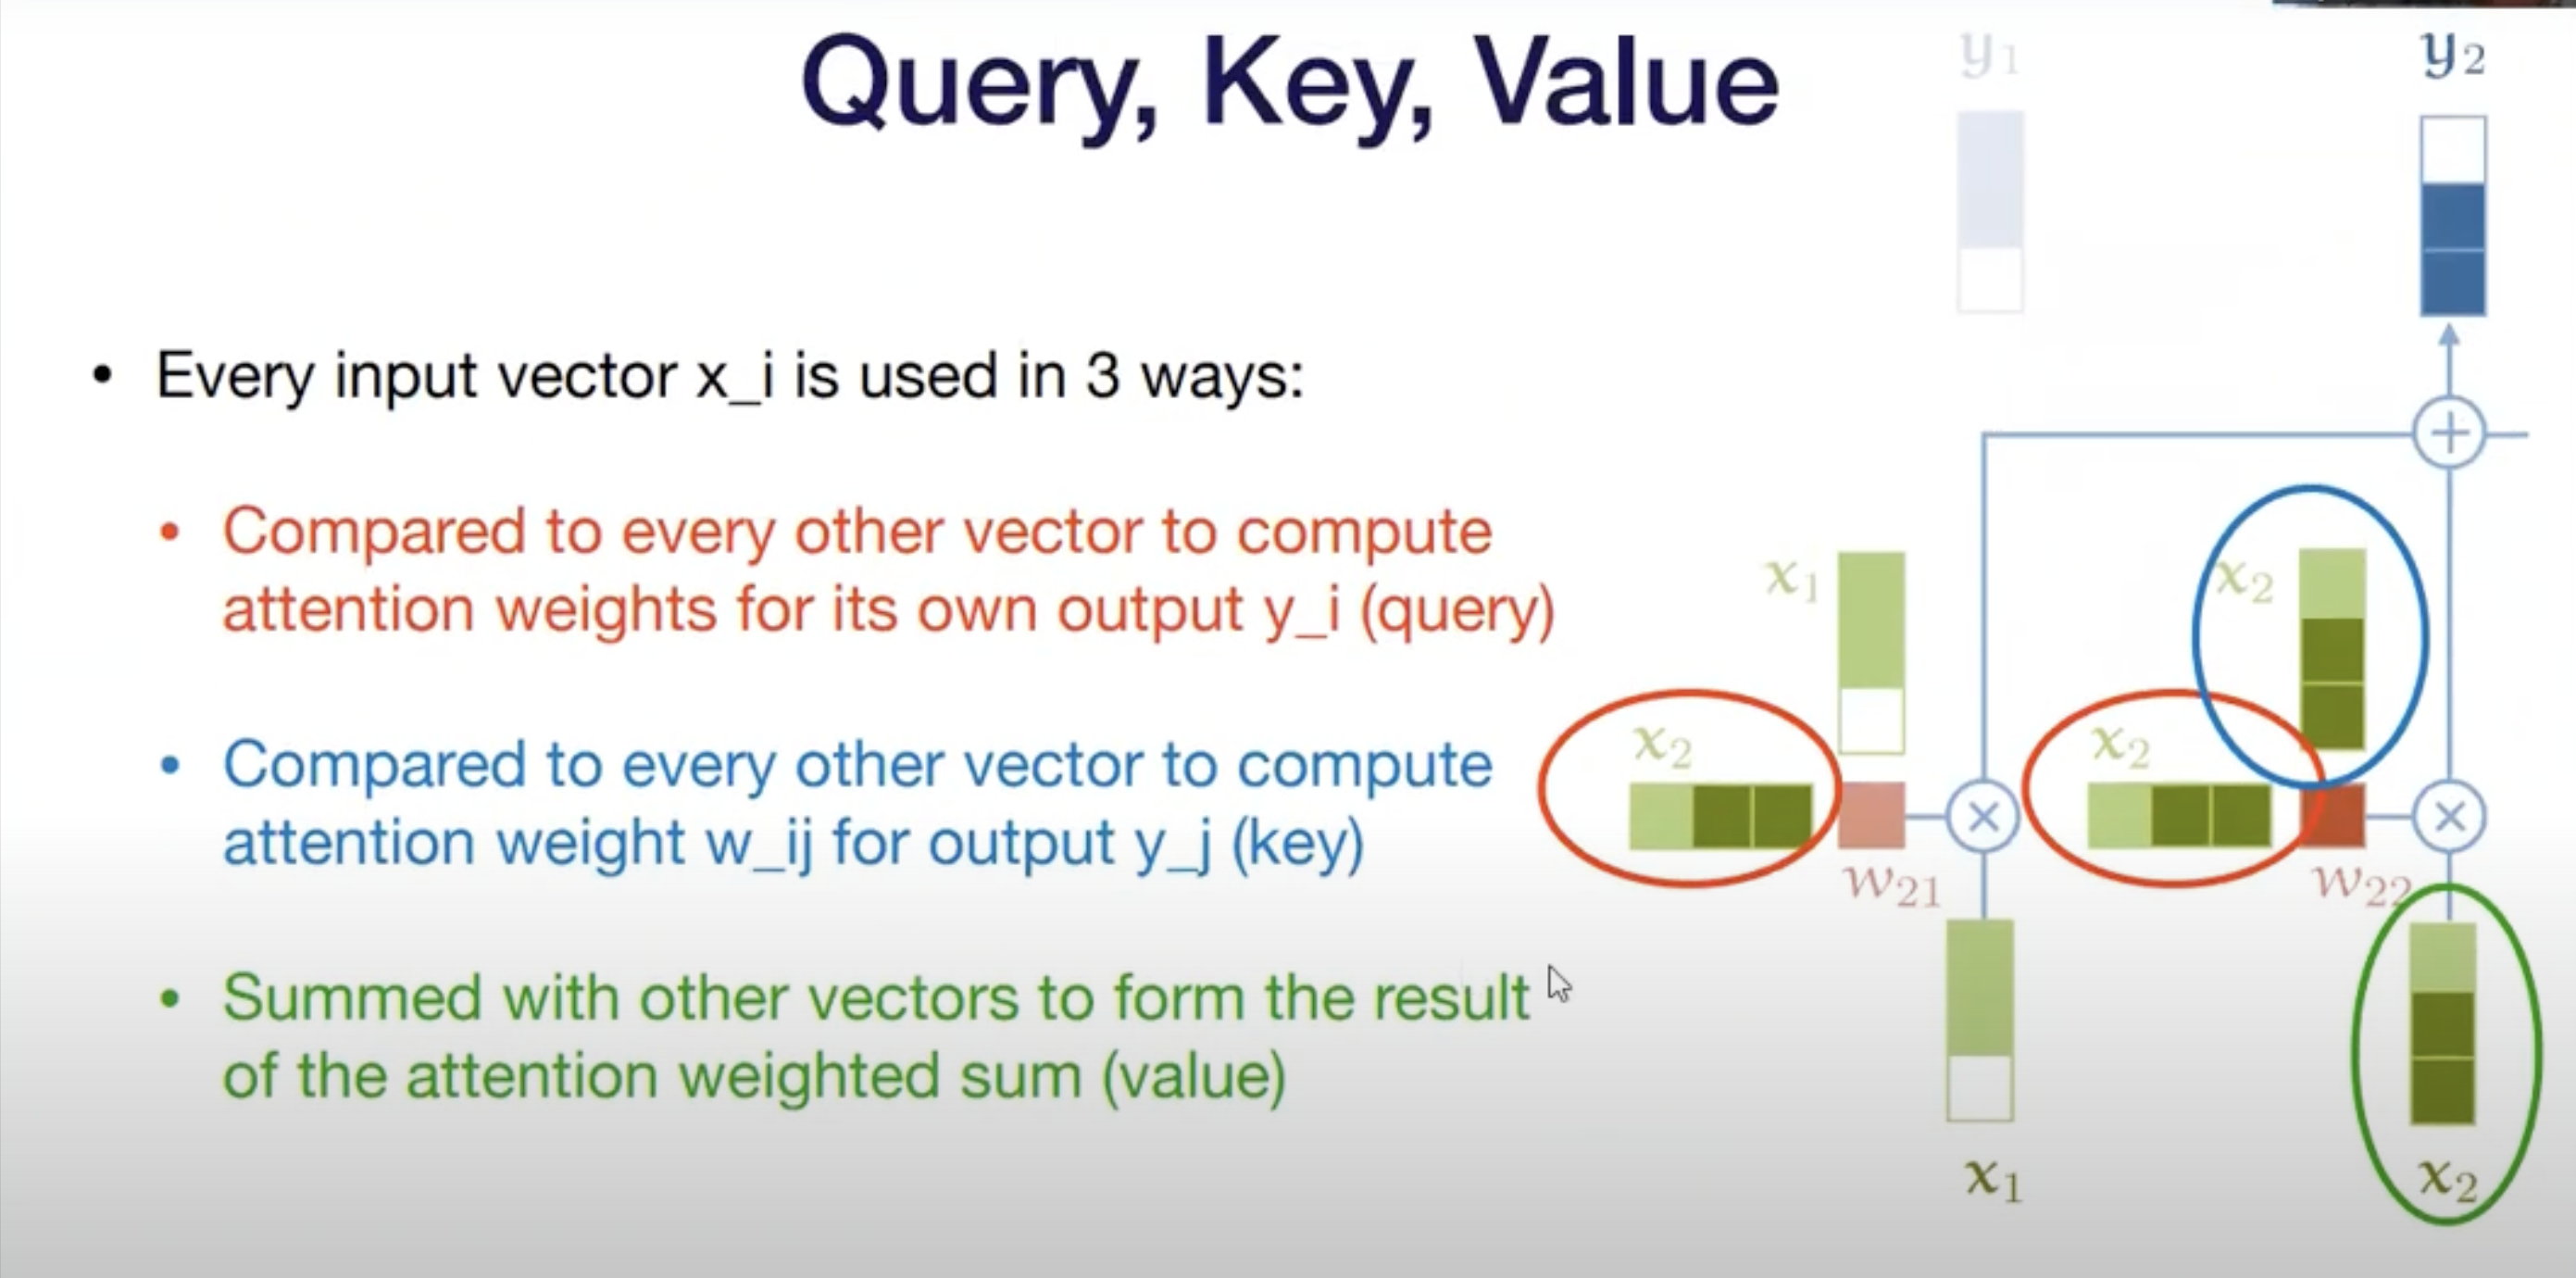

# RAG

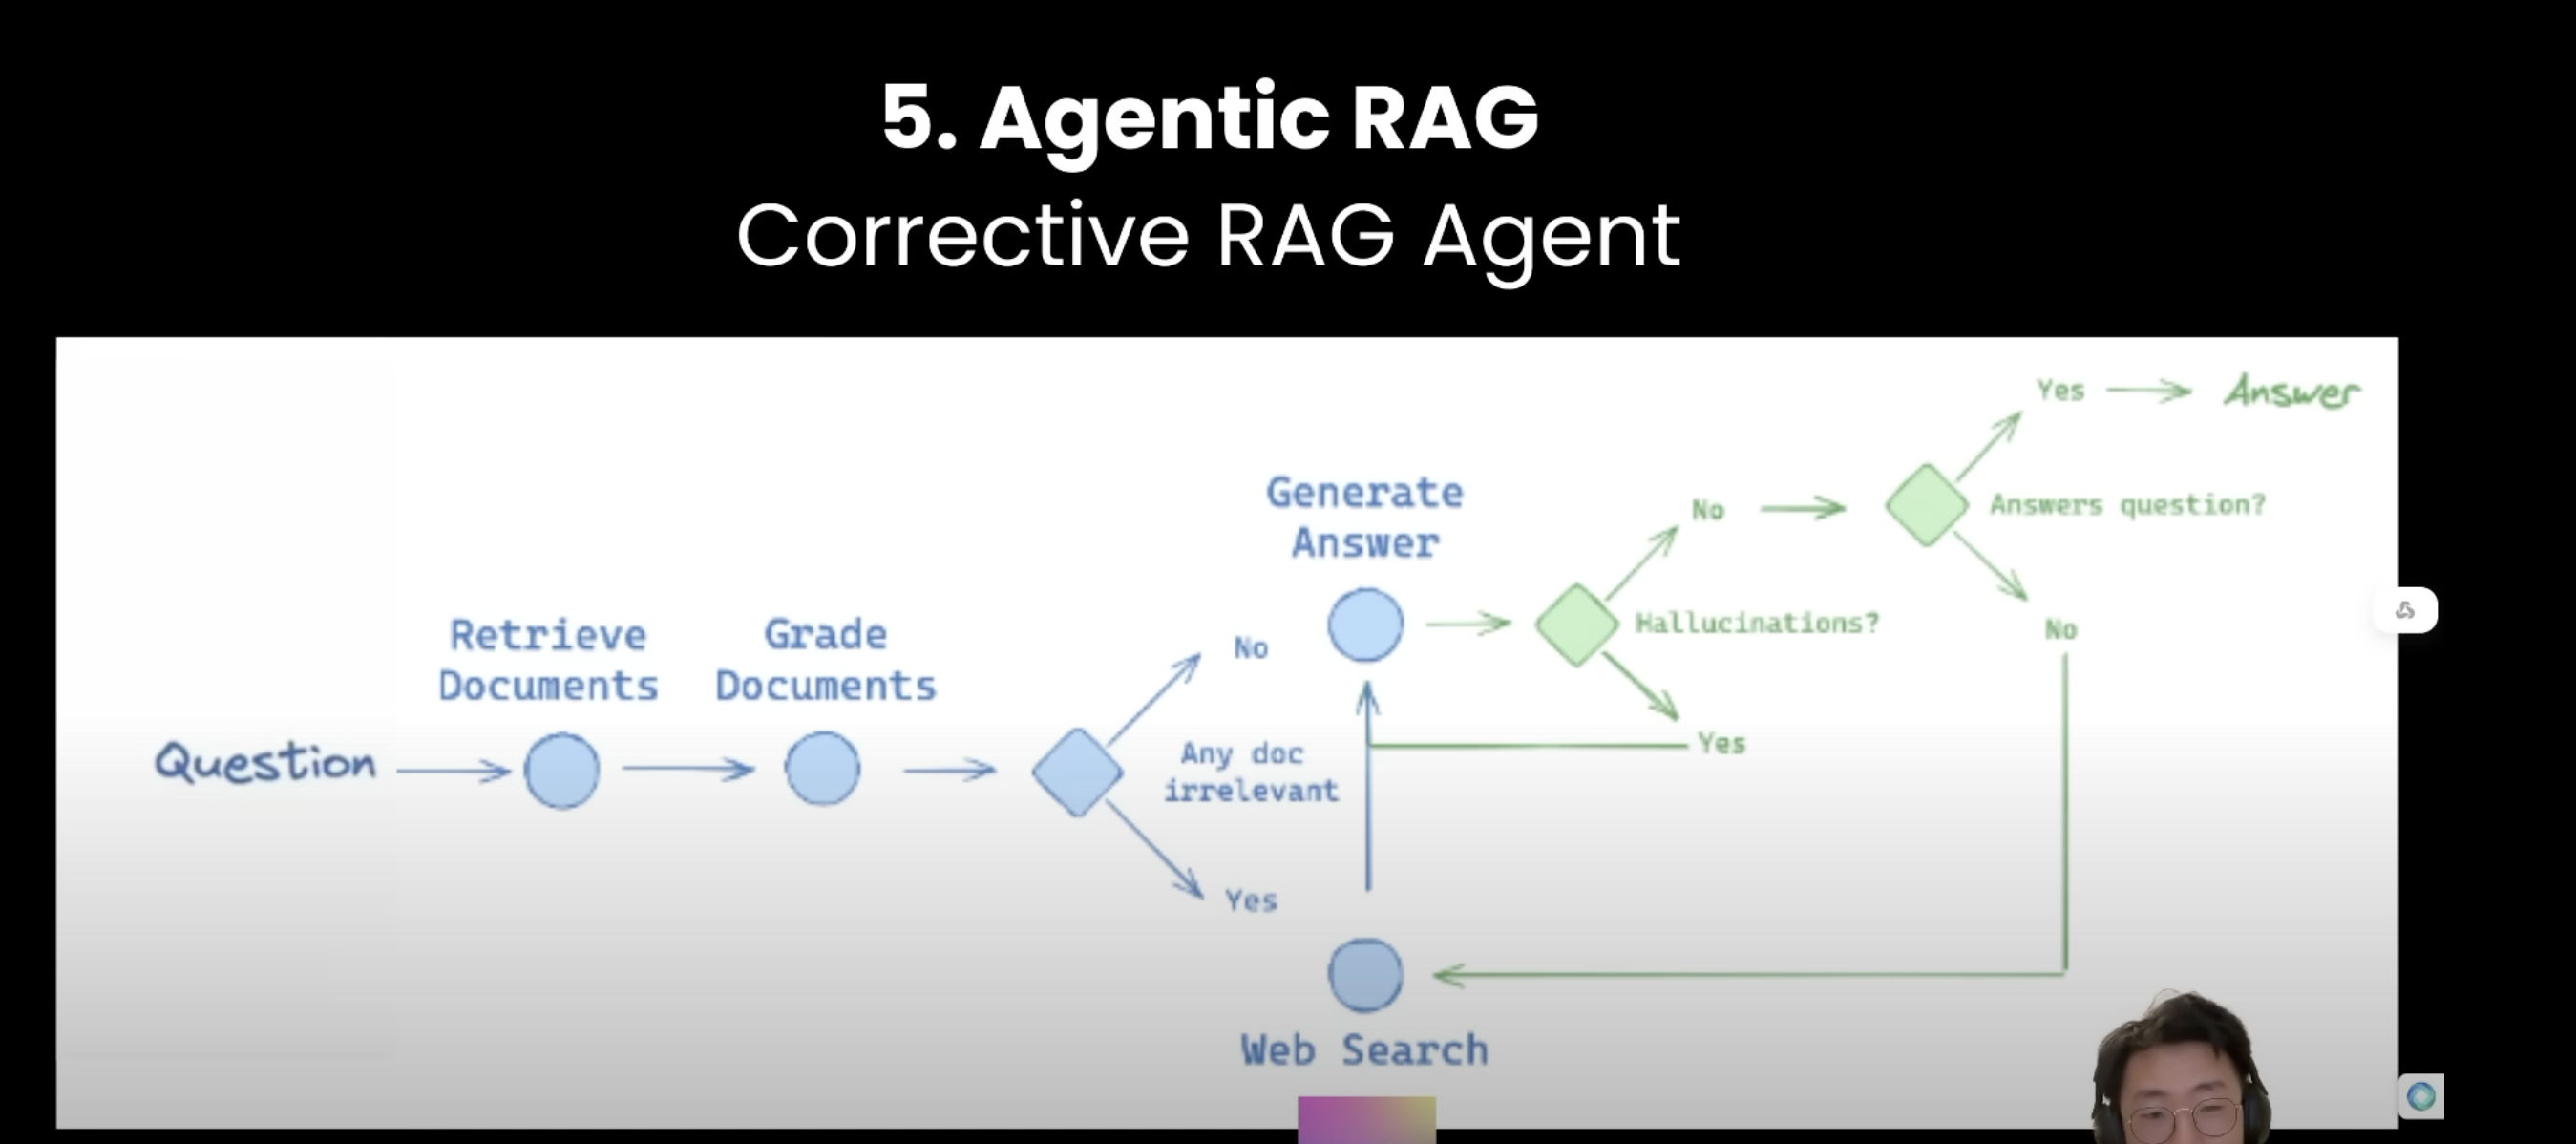

In [2]:
# %pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all

In [1]:
from langchain_community.embeddings import GPT4AllEmbeddings
"""
This script imports the GPT4AllEmbeddings class from the langchain_community.embeddings module.

GPT4AllEmbeddings is a class designed to generate embeddings using the GPT-4 model. Embeddings are numerical representations of text that capture semantic meaning, which can be used in various natural language processing (NLP) tasks such as similarity comparison, clustering, and classification.
"""


/Users/mp/.pyenv/versions/3.10.10/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in GPT4AllEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


'\nThis script imports the GPT4AllEmbeddings class from the langchain_community.embeddings module.\n\nGPT4AllEmbeddings is a class designed to generate embeddings using the GPT-4 model. Embeddings are numerical representations of text that capture semantic meaning, which can be used in various natural language processing (NLP) tasks such as similarity comparison, clustering, and classification.\n'

In [2]:
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def get_retriever(persist_directory="rag-chroma-store",
             collection_name="rag-chroma-store",
             docs_dir = 'data', 
             chunk_size=100,
             refresh=False):
  embeddings = GPT4AllEmbeddings()
  vectordb = Chroma(persist_directory=persist_directory, 
                    collection_name=collection_name, 
                    embedding_function=embeddings)
  ids = vectordb.get(limit=1)['ids']
  print(ids)
  if len(ids) and not refresh: return vectordb.as_retriever()
  docs = DirectoryLoader(docs_dir, glob="./*.txt", loader_cls=TextLoader).load()
  doc_chunks = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_size//10,
    length_function=len
    ).split_documents(documents=docs)
  vectordb.add_documents(documents=doc_chunks)
  return vectordb.as_retriever()

In [3]:
# expand
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

class MyJsonOutputParser(JsonOutputParser):
    def __init__(self) -> None:
        super().__init__()
    
    def parse(self, text: str) -> list[str]:
      print('MyJsonOutputParser', text)
      dictout = super().parse(text)
      return list(dictout.keys()) + list(dictout.values())

def expand(query, N, llm):
  EXPAND_PROMPT=PromptTemplate(
    input_variables=["question", "N"],
    template="""You are an AI language model assistant. Your task is to generate {N}
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}"""
    )
  # llm_chain = EXPAND_PROMPT | llm | MyJsonOutputParser()
  llm_chain = EXPAND_PROMPT | llm | StrOutputParser()
  try:
    queries_str = llm_chain.invoke({"question": query, "N": N})
    queries = queries_str.splitlines()[:N]
    print(query, f"* {N} -> ", queries)
    return queries
  except ConnectionRefusedError as cre:
     print("Local LLM isn't running. Please start it.")
     raise cre


In [4]:
### Retrieval Grader
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

def grade_ret_chunks(query, chunks, json_llm):
  RETR_GRADE_PROMPT = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved documents to a user question. If the documents contain keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n 
    Give a binary score 'yes' or 'no' score to indicate whether documents are relevant to the question. \n 
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination. 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved documents: \n\n {documents} \n\n
    Here is the user question: {question} In <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """, 
    input_variables=["question", "documents"])
  retr_grader = RETR_GRADE_PROMPT | json_llm | JsonOutputParser()
  return retr_grader.invoke({"question": query, "documents": chunks})

# question = "what do i like?"

# docs = retriever.invoke(question)
# doc_txt = docs[1].page_content
# print (retrieval_grader. invoke({"question": question, "document": doc_txt}))

In [5]:
# %pip install protobuf==3.20.0
import sentence_transformers as st

def bi_rank(query, bi_encoder, docs):
  doc_texts = [doc.page_content for doc in docs]
  query_embedding = bi_encoder.encode(query, convert_to_tensor=True)
  doc_embeddings =  bi_encoder.encode(doc_texts, convert_to_tensor=True)
  bi_scores = st.util.pytorch_cos_sim(query_embedding, doc_embeddings)[0]
  # zip
  bi_ranked_docs = sorted(zip(bi_scores,    docs), key=lambda x: x[0], reverse=True)
  return bi_ranked_docs

def cross_rank(query, cross_encoder, docs):
  doc_texts = [doc.page_content for doc in docs]
  cross_scores = cross_encoder.predict([[query, doc] for doc in doc_texts])
  # zip
  cross_ranked_docs = sorted(zip(cross_scores, docs), key=lambda x: x[0], reverse=True)
  return cross_ranked_docs


/Users/mp/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
def get_unique_docs(docs):
  print('get_unique_docs',docs[0])
  unique_contents = set()
  unique_docs = []
  for doc in docs:
      # print('sublist',sublist)
      # for doc in sublist:
      print('doc',doc)
      if doc.page_content in unique_contents: continue
      unique_docs.append(doc)
      unique_contents.add(doc.page_content)
  return unique_docs

def rerank(query, rel_chunks, n_top, cross=False):
  print(n_top, "best chunks using", "cross-encoder" if cross else "bi-encoder", "for query: ", query)
  bi_encoder = st.SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
  cross_encoder = st.CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

  unique_chunks = get_unique_docs(rel_chunks)

  ranked = cross_rank(query, cross_encoder, unique_chunks) if cross else bi_rank(query, bi_encoder, unique_chunks)
  sorted_docs = sorted(ranked, reverse=True)
  reranked_docs = [doc for _, doc in sorted_docs][:n_top]

  def print_scored(ranked):
    print("\n".join([str(round(float(r[0]), 4)) + " " + r[1].metadata['source'] + " " + r[1].page_content[:20] for r in ranked]))
  
  print_scored(ranked)
  return reranked_docs


In [7]:

def generate(str_llm):
  generator = GENERATOR_PROMPT | str_llm | StrOutputParser()


In [8]:
def grade_hallucinations(generation, documents, llm):
  HALLUC_PROMPT = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. </eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ----- \n 
    {documents}
    \n ----- \n 
    Here is the answer: {generation} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
  input_variables= ["generation", "documents"])
  hall_grader = HALLUC_PROMPT | llm | JsonOutputParser()
  return hall_grader.invoke({"documents": documents, "generation": generation})

# Main

![rag-augmentations](<attachment:Screenshot 2024-10-09 at 20.30.49.png>)
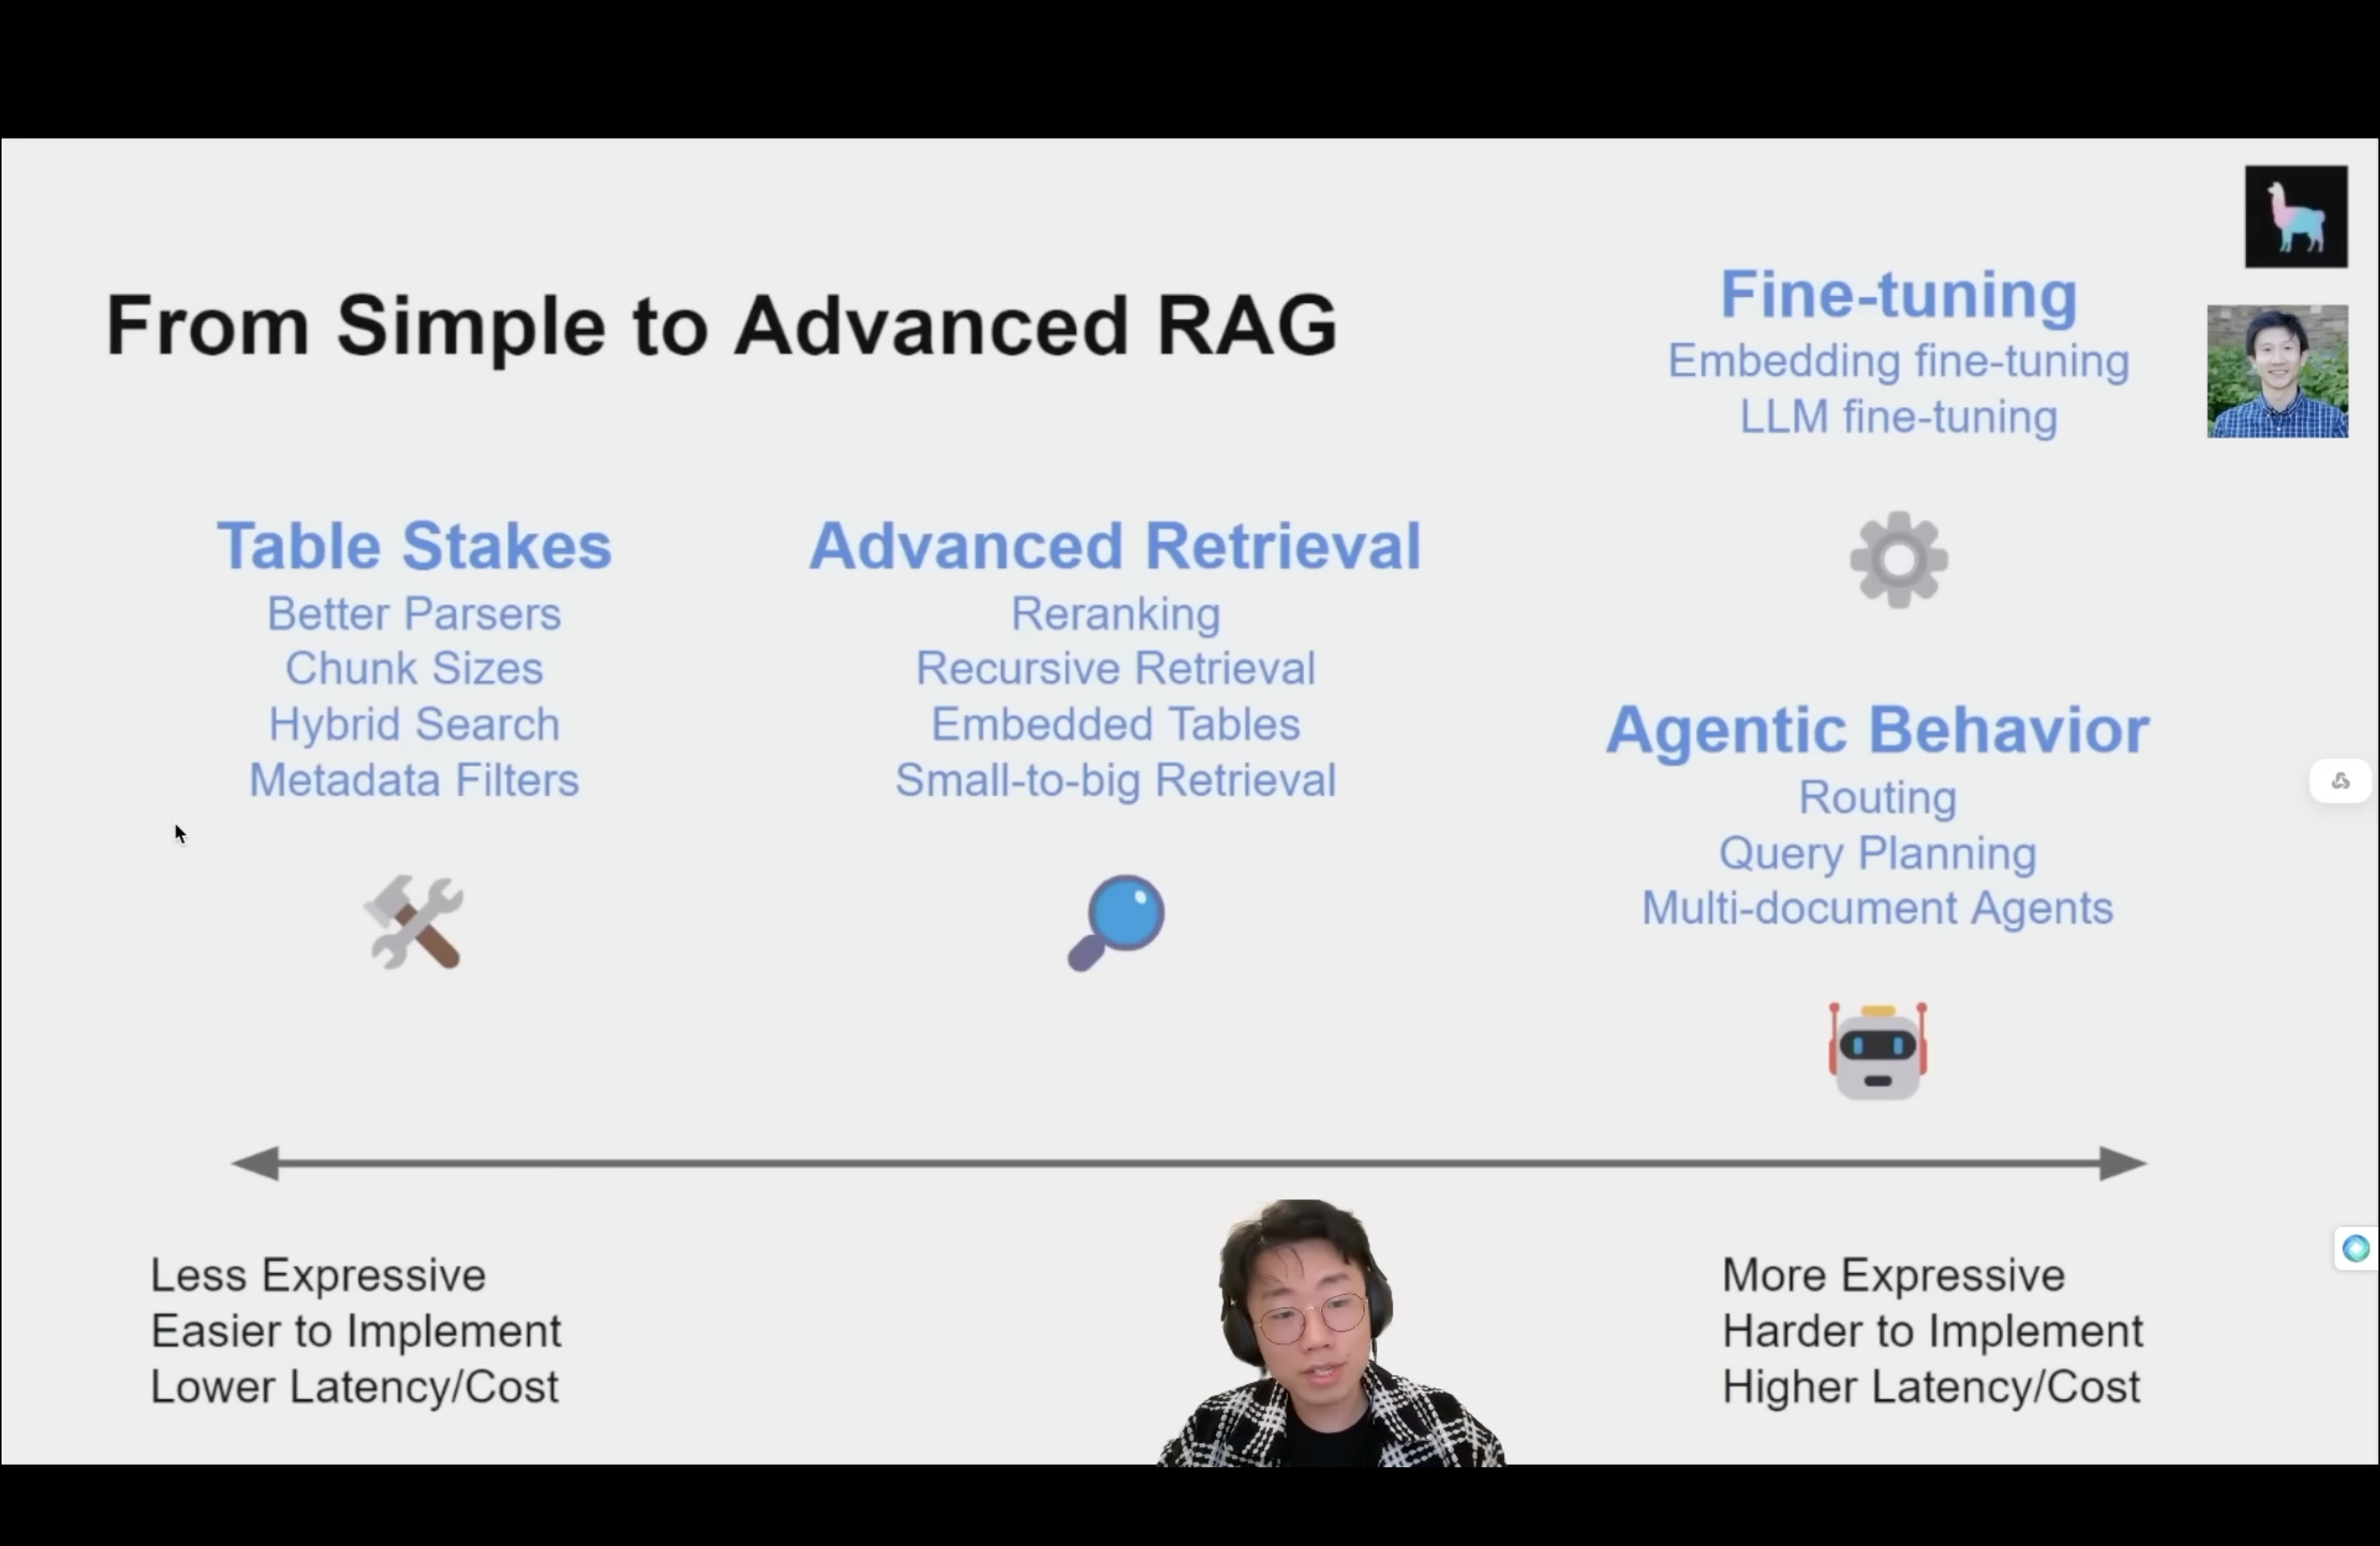

In [9]:
# TODO 1 ---> make it all work
import time
from langchain_community.chat_models import ChatOllama

query = "Any Machine Learning jobs in Austin?"
local_llm = 'llama3.1'

str_llm = ChatOllama(model=local_llm, temperature=0)
json_llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Expand
a_time = time.time()
N_QUERIES = 2
queries = expand(query, N_QUERIES, str_llm)
print(f"Expand: {round(time.time() - a_time, ndigits=3)} s", end="\n\n")


Any Machine Learning jobs in Austin? * 2 ->  ['Any Machine Learning jobs available in Travis County, Texas?', 'What are the top 5 cities with the highest number of Machine Learning job postings in the United States, and does Austin rank among them?']
Expand: 2.393 s



In [10]:

# Retrieve
a_time = time.time()
retriever = get_retriever()
rel_chunks = [ret for query in queries for ret in retriever.invoke(query)]
print("relevant chunks:")
chunk_contents = [d.page_content for d in rel_chunks]
print(chunk_contents)
print(f"Retrieve: {N_QUERIES} queries {round(time.time() - a_time, ndigits=3)} s", end="\n\n")
# calc_global_embeddings("Job status", embeddings, retriever, global_embeddings_2d)


[]
relevant chunks:
['Machine Learning Engineer - Strategic Data Solutions\nAustin, Texas, United States', 'Apple Neural Engine Driver Engineer\nSunnyvale, California, United States\nSoftware and Services', 'As an SDS machine learning engineer, you will work with teams across Apple, using data analysis and', 'Graduate degree with research/work experience utilizing data science techniques (including but not', 'Machine Learning Engineer - Strategic Data Solutions\nAustin, Texas, United States', 'Apple Neural Engine Driver Engineer\nSunnyvale, California, United States\nSoftware and Services', "machine learning, data engineering, and software engineering, etc) to improve your team's overall", 'Our Apple Neural Engine Driver team is looking for an outstanding engineer to drive powerful']
Retrieve: 2 queries 1.216 s



In [11]:

# Grade
a_time = time.time()
graded = grade_ret_chunks(query, rel_chunks, json_llm) # www if irrelevant
print(graded)
print(f"Grade: {len(rel_chunks)} chunks ({len(set(chunk_contents))} unique) {round(time.time() - a_time, ndigits=3)} s", end="\n\n")


{'score': 'yes'}
Grade: 8 chunks (6 unique) 2.325 s



In [12]:
from langchain_community.document_transformers import LongContextReorder

# Rerank
ranked = rerank(query, rel_chunks, n_top=3, cross=False)

# withoutlimp = reordered_docs(ranked)
withoutlimp = LongContextReorder().transform_documents(ranked)


3 best chunks using bi-encoder for query:  Any Machine Learning jobs in Austin?
get_unique_docs page_content='Machine Learning Engineer - Strategic Data Solutions
Austin, Texas, United States' metadata={'source': 'data/doc4.txt'}
doc page_content='Machine Learning Engineer - Strategic Data Solutions
Austin, Texas, United States' metadata={'source': 'data/doc4.txt'}
doc page_content='Apple Neural Engine Driver Engineer
Sunnyvale, California, United States
Software and Services' metadata={'source': 'data/doc2.txt'}
doc page_content='As an SDS machine learning engineer, you will work with teams across Apple, using data analysis and' metadata={'source': 'data/doc4.txt'}
doc page_content='Graduate degree with research/work experience utilizing data science techniques (including but not' metadata={'source': 'data/doc4.txt'}
doc page_content='Machine Learning Engineer - Strategic Data Solutions
Austin, Texas, United States' metadata={'source': 'data/doc4.txt'}
doc page_content='Apple Neural E

In [13]:
GENERATOR_PROMPT = PromptTemplate(
  template="""<|begin_of_text|> <|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
  Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
  Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
  Question: {question}
  Context: {context}
  Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""", 
input_variables=["question", "document"])

generator = GENERATOR_PROMPT | str_llm | StrOutputParser()
generator_output = generator.invoke({"context": ranked, "question": query})
generator_output

"Yes, there is a Machine Learning job available in Austin, Texas. The job title is Machine Learning Engineer - Strategic Data Solutions. It can be found on the source 'data/doc4.txt'."

In [14]:
grade_hallucinations(rel_chunks, generator_output, json_llm)

{'score': 'yes'}


🟢 Simplest
- Better Parsers
- chunk size experiments for optimal Chunk Size Avg Response Time (s) Avg Faithfulness Avg Relevancy
- Hybrid Search - vector search + keyword search
- Metadata Filters

🟡 Advanced Retrieval
- Reranking - select top N docs from retriever
- Recursive Retrieval 
- Embedded Tables
- Small-to-big Retrieval

🔴 Fine-tuning
- Embedding fine-tuning
- LLM fine-tuning

⚫️ Agentic Behavior
- Routing - choose DB based on metadata
- Query Planning - Ben went to which school between Aug 1954 and Nov 1954? -> What was Ben's education history? 
- Multi-document Agents
- More Expressive
- Harder to Implement Higher Latency/Cost

In [3]:
# TODO 2 ---> all simplest + 1 medium


In [ ]:
# TODO 3 ---> wrap in graph

# Define the nodes
workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
  "grade_documents", decide_to_generate,
  websearch="websearch",
  generate="generate"
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
  "generate", grade_generation_v_documents_and_question,
  not_supported="generate",
  useful=END,
  not_useful="websearch"
)